# Transfer Learning

There are two major transfer learning scenarios:

-  **Finetuning**: Instead of randomly initializing the weights for training , we initialize the network with pretrained weights on a bigger dataset such as imagenet (1M images and 1K class). 
-  **Feature extractor**: we initialize the network with pre-trained weights, similar to the previous, but instead of training the whole network, we freeze all the weights (from Convolutional layers / backbone) except those of the final fully connected layer (head). This last fully connected layer is replaced with a new one with random weights and only this layer is trained.

In [ ]:
import os    
import torch 
import torchvision
import pandas as pd  
import numpy as np  
from torch.utils.data import Dataset, random_split, DataLoader  
from PIL import Image  
import torchvision.models as models  
import torchvision.transforms as transforms  
from torchvision import datasets  
import torch.nn.functional as F  
import torch.nn as nn  
from torchvision.utils import make_grid  
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt  

%matplotlib inline

# 1. Data

In [ ]:
#!pip install kaggle

#! mkdir ~/.kaggle

#! cp kaggle.json ~/.kaggle/

#! chmod 600 ~/.kaggle/kaggle.json

os.environ['KAGGLE_USERNAME'] = "ADD YOURS"
os.environ['KAGGLE_KEY'] = "ADD YOURS"

!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:49<00:00, 33.1MB/s]
100% 2.29G/2.29G [00:49<00:00, 49.9MB/s]


In [ ]:
!unzip chest-xray-pneumonia.zip 

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [ ]:
data_dir = "./chest_xray/"
TEST_DIR = data_dir +'/test'
TRAIN_DIR = data_dir +'/train'
VAL_DIR = data_dir + '/val'

# [Source: https://stackoverflow.com/questions/58151507/why-pytorch-officially-use-mean-0-485-0-456-0-406-and-std-0-229-0-224-0-2]
#Using the mean and std of Imagenet is a common practice. They are calculated based on millions of images. 
#If you want to train from scratch on your own dataset, you can calculate the new mean and std. 
#Otherwise, using the Imagenet pretrianed model with its own mean and std is recommended.
mean , std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Resize((224,224),interpolation=Image.NEAREST),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
val_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Resize((224,224),interpolation=Image.NEAREST),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
test_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Resize((224,224),interpolation=Image.NEAREST),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

train_data = datasets.ImageFolder(TRAIN_DIR,transform=train_transforms)
valid_data = datasets.ImageFolder(VAL_DIR, transform=val_transforms)
test_data = datasets.ImageFolder(TEST_DIR,transform=test_transforms)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [ ]:
batch_size = 4

train_dl = DataLoader(train_data,batch_size=batch_size,shuffle=True, num_workers=2)
valid_dl = DataLoader(valid_data,batch_size=batch_size, num_workers=2)
test_dl = DataLoader(test_data,batch_size=batch_size,num_workers=2)

In [ ]:
def denormalize(images, means, stds):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_image(img_tensor, label):
    print('Label:', train_data.classes[label], '(' + str(label) + ')')
    img_tensor = denormalize(img_tensor, mean, std)[0].permute((1, 2, 0))
    plt.imshow(img_tensor)

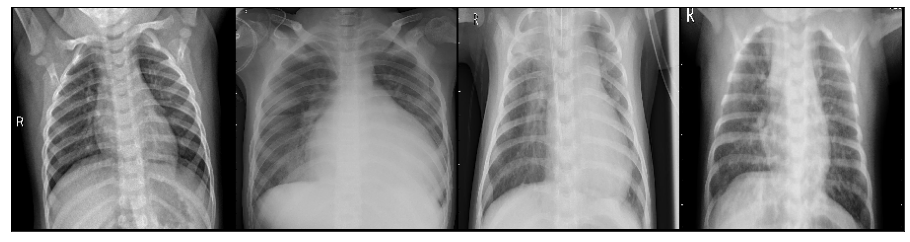

In [ ]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 16))
        ax.set_xticks([]); ax.set_yticks([])
        images = denormalize(images[:64], mean, std)
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

show_batch(train_dl)

# 2. Model

## Fine-tunning

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
class_names = train_data.classes
class_names

['NORMAL', 'PNEUMONIA']

#### Original ResNet-50

In [ ]:
resnet = models.resnet50(pretrained=True)

In [ ]:
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Fine-Tune model

In [ ]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

In [ ]:
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
from torchsummary import summary
summary(model_ft, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=learning_rate, momentum=0.9)

# 3. Training

### **Overfitting**
![Image of Yaktocat](https://i.imgur.com/tHiVFnM.png)

### **Early Stopping**
![Image of Yaktocat](https://i.imgur.com/eP0gppr.png)

In [ ]:
class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience=3, min_delta=0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model = './cifar_best_net.pth'

    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            torch.save(model_ft.state_dict(), self.best_model)
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [ ]:
early_stopping = EarlyStopping()

In [ ]:
def evaluate():
  running_loss = 0.0
  
  with torch.no_grad():
    for i, data in enumerate(valid_dl, 0):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data

      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model_ft(inputs)
      loss = criterion(outputs, labels)
      running_loss += loss.item()
  val_loss = running_loss / len(valid_dl)
  print('val loss: %.3f' % (val_loss))
  return val_loss


def eval_acc(train=False):
  correct = 0
  total = 0
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      loader = train_dl if train else valid_dl
      for data in loader:
          images, labels = data
          images = images.to(device)
          labels = labels.to(device)
          # calculate outputs by running images through the network
          outputs = model_ft(images)
          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  
  print('Accuracy of the network on the %s images: %d %%' % (
      'train' if train else 'test', 100 * correct / total))

In [ ]:
def train():
  NUM_EPOCHS = 10
  for epoch in range(NUM_EPOCHS):  # loop over the dataset multiple times
      print(f'Epoch {epoch+1}:')
      running_loss = 0.0
      for i, data in enumerate(train_dl, 0):
          # get the inputs; data is a list of [inputs, labels]
          #inputs, labels = data
          inputs, labels = data[0].to(device), data[1].to(device) #set for GPU if available

          # zero the parameter gradients
          optimizer_ft.zero_grad()

          # forward + backward + optimize
          outputs = model_ft(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer_ft.step()

          # print statistics
          running_loss += loss.item()
          if i % 250 == 0 and i!= 0: 
              print(f'Iteration {i}, loss = {(running_loss / 250):.3f}')
              running_loss = 0.0

      val_loss = evaluate()
      eval_acc()
      early_stopping(val_loss)
      if early_stopping.early_stop:
          break

  print('Finished Training')

In [ ]:
train()

Epoch 1:
Iteration 250, loss = 0.347
Iteration 500, loss = 0.140
Iteration 750, loss = 0.175
Iteration 1000, loss = 0.118
Iteration 1250, loss = 0.127
val loss: 3.194
Accuracy of the network on the test images: 56 %
Epoch 2:
Iteration 250, loss = 0.090
Iteration 500, loss = 0.092
Iteration 750, loss = 0.070
Iteration 1000, loss = 0.066
Iteration 1250, loss = 0.137
val loss: 2.253
Accuracy of the network on the test images: 56 %
Epoch 3:
Iteration 250, loss = 0.016
Iteration 500, loss = 0.094
Iteration 750, loss = 0.035
Iteration 1000, loss = 0.020
Iteration 1250, loss = 0.069
val loss: 2.680
Accuracy of the network on the test images: 62 %
INFO: Early stopping counter 1 of 3
Epoch 4:
Iteration 250, loss = 0.065
Iteration 500, loss = 0.012
Iteration 750, loss = 0.039
Iteration 1000, loss = 0.048
Iteration 1250, loss = 0.042
val loss: 1.023
Accuracy of the network on the test images: 68 %
Epoch 5:
Iteration 250, loss = 0.014
Iteration 500, loss = 0.025
Iteration 750, loss = 0.027
Iterati

In [ ]:
PATH = './chest_xray.pth'
torch.save(model_ft.state_dict(), PATH)

## Feature extractor

In [ ]:
# Parameters of newly constructed modules have requires_grad=True by default

model_extractor = torchvision.models.resnet50(pretrained=True)
for param in model_extractor.parameters():
    param.requires_grad = False

num_ftrs = model_extractor.fc.in_features
model_extractor.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model_extractor.to(device)

Then repeat same process ...